In [14]:
# 라이브러리를 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

# 글꼴 깨짐 방지
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] =False

# 데이터 프레임 
df = pd.read_csv("/Users/b26/Desktop/미니프로젝트/패스트캠퍼스 데이터분석/실습데이터.csv")

#MeCab 사용
from konlpy.tag import Mecab
from PIL import Image
import nltk
import os
import re

# Word Cloud
from wordcloud import WordCloud



# 강의 제목 키워드 추출

In [15]:
mecab = Mecab()

In [16]:
FEATURE_POS = ['NNG', 'NNP', 'NNB', 'NNBC', 'NR',
               'NP', 'VV', 'VA', 'MAG'] 
#mecab 기준, 명사 & 형용사 & 동사 & 부사


def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 패턴.
    # doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    
    # 특수문자를 제거하는 패턴.
    doc = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", " ", doc)
    # e.g. codingiscoffee@gmail.com 을 고려해서 " "로 했음
    
    # 영문 빼고 모두 제거하는 패턴.
    #doc = doc.replace("\n", " ")
    #doc = re.sub("[^A-Za-z ]", "", doc)
    
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    SW.add("있어요")
    SW.add("대한")
    SW.add("합니다")
    SW.add("하는")
    SW.add("보다")
    SW.add("한다")
    SW.add("가능")
    
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding="utf-8") as f:
        for word in f:
            SW.add(word.strip())
            
    return SW

def text_tokenizing(doc, tokenizer):
    """
    Input Parameter :
    
    doc - tokenizing 하는 실제 데이터
    tokenizer - token의 단위.
    """
    tok = mecab  # 형태소 분석기 선언.
    
    
    if tokenizer == "words":
        return [word for word in doc.split() if word not in SW and len(word) > 1]
    
    elif tokenizer == "nouns":
        # 명사만 뽑아주는 함수 .nouns --> return []
        return [token for token in tok.nouns(doc) if token not in SW and len(token) > 1]
        
    elif tokenizer == "morphs":
        # 형태소로 나눔
        return [token for token in tok.morphs(doc) if token not in SW and len(token) > 1]    
    
    elif tokenizer == "predefined":
        
        documents = []
        text_pos = [pair for pair in tok.pos(doc) if pair[0] not in SW and len(pair[0]) > 1]
        words = []

        for word, pos in text_pos:
            if pos in FEATURE_POS:
                words.append(word)

        return words

In [17]:
tokenizer = "predefined"

In [18]:
SW = define_stopwords("./stopwords-ko.txt")

In [19]:
document = df
documents = document["코스(상품) 이름"]  # 
# cleaned_docs = text_cleaning(documents)
# tokenized_docs = text_tokenizing(cleaned_docs)
tokenized_documents = documents.apply(text_cleaning)\
                                .apply(lambda x : text_tokenizing(x,tokenizer))
#   .apply(func=text_tokenizing, tokenizer = tokenizer)
# 2D list
# tokenized_docs = documents.apply(text_cleaning)\
                # .apply(lambda x : text_tokenizing(x,tokenizer))

tokenized_documents

0                          [올인원, 패키지, 왼손, 파이썬, 업무, 자동, 유치원]
1                                [격차, 패키지, 끝내, 부동산, 금융, 실무]
2         [편집, 여자, 영상, 편집, 마스터클래스, 다양, 효과, 응용, 애프터, 이펙트,...
3                                   [격차, 패키지, 프로젝트, 배우, 개발]
4               [격차, 패키지, 개발자, 취업, 합격, 패스, 코딩, 테스트, 기술, 면접]
                                ...                        
159323                [올인원, 패키지, 월급, 만들, 직장, 스몰, 비즈니스, 가이드]
159324                   [미디어, 아트, 그래픽, 클래스, 모션, 그래픽, 패러다임]
159325                        [올인원, 패키지, 파이썬, 활용, 데이터, 전처리]
159326                         [올인원, 패키지, 움직이, 가지, 디자인, 원칙]
159327                      [올인원, 패키지, 머신, 러닝, 서비스, 구축, 실전]
Name: 코스(상품) 이름, Length: 159328, dtype: object

# Word Cloud
## TD-IDF 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

#TfidfVectorizer의 input으로 만들기 위한 전처리.
tfidf_docs = [" ".join(L) for L in tokenized_documents]

tfidf = TfidfVectorizer()
# X_tfidf.toarray()  #numpy array 로 변환해줌

# tfidf Document-Term Matrix로 변환
X_tfidf = tfidf.fit_transform(tfidf_docs)

terms = tfidf.get_feature_names()  # 사전(가나다)순으로 정렬.

tfidf_df = pd.DataFrame(data = X_tfidf.toarray(),
                        columns=terms)

display(tfidf_df)

# sum tfidf frequency of each term through documents
sums = X_tfidf.sum(axis=0) ##mean(=sum)   vs max

# connecting term to its sums frequency
df = []
for col, term in enumerate(terms):
    df.append( (term, sums[0,col] ))

ranking = pd.DataFrame(df, columns=['Term','TF-IDF'])
rankInfo = ranking.sort_values('TF-IDF', ascending=False)[:50]

x = list(rankInfo["Term"])
y = list(rankInfo["TF-IDF"])

tfidfInfo = dict()

for vocab, tfidf in zip(x, y):
    tfidfInfo[vocab] = tfidf

print(x[:5])
print(y[:5])
print()
print(rankInfo)

/opt/homebrew/Caskroom/miniconda/base/envs/test/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,가득,가볍,가이드,가장,가지,가치,감각,감독,감성,감지,...,활용,황선미,회계,회계사,회사,회수,효과,효율,후디니,히어로
0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.299478,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159323,0.0,0.0,0.411488,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
159324,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
159325,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.377679,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
159326,0.0,0.0,0.000000,0.0,0.48518,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


['패키지', '격차', '끝내', '올인원', '개발']
[17589.41183517454, 16588.83440227439, 14365.492547245625, 9767.201200824444, 8135.348620352565]

      Term        TF-IDF
622    패키지  17589.411835
25      격차  16588.834402
87      끝내  14365.492547
409    올인원   9767.201201
14      개발   8135.348620
119    데이터   5758.470139
648   프로젝트   5366.859160
220     배우   5043.614450
134    디자인   4691.748664
345     실무   4186.559605
142     러닝   4169.739315
235     분석   3877.663860
649  프론트엔드   3770.225298
410     완성   3023.127900
162    마스터   2880.128457
471   일러스트   2875.218261
357   아카데미   2801.914819
684     활용   2797.663245
615    파이썬   2773.652131
513     정복   2383.755262
659     필수   2376.839388
411     완전   2368.055500
387     엔드   2340.507883
279    서비스   2254.202719
47      구축   2220.960398
631     편집   2192.709407
573    캐릭터   2144.494182
463   인공지능   2127.988127
166     만드   2006.492951
399     영상   1962.137399
551     처리   1957.399991
579    컴퓨터   1906.878621
385     엑셀   1894.047241
318     스킬   1889.7

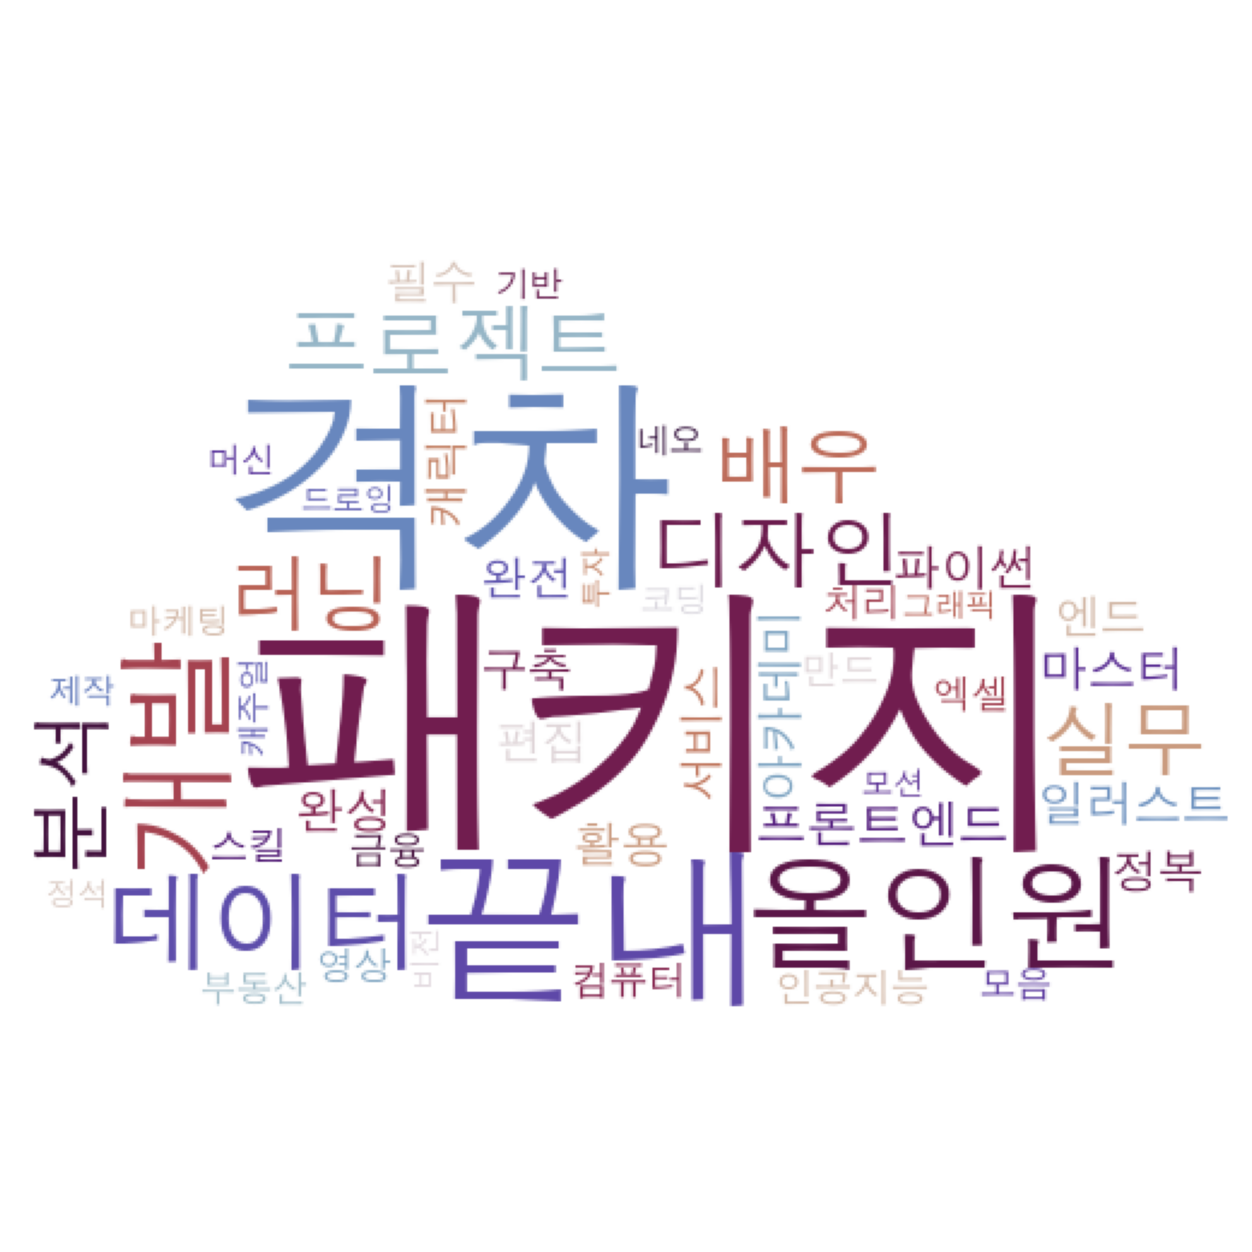

In [21]:
### 워드클라우드에 들어갈 단어 갯수 변경.

# for windows : font_path='c:/Windows/Fonts/malgun.ttf'
# for macOS : font_path = "/usr/share/fonts/nanumfont/NanumGothic.ttf"

# 워드클라우드 만들 배경 그림 경로. ex) cloud.png

mask = np.array(Image.open("./cloud.png"))
wordcloud = WordCloud(font_path = "AppleGothic",
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      mask=mask,
                      background_color='white',
                      colormap="twilight"
                      ).generate_from_frequencies(tfidfInfo)
plt.figure(figsize=(16,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("./wordcloud_naverNews(tfidf).png")
plt.show()

# 핵심 키워드 별, 실구매강의 점유율 파악

In [22]:
Top_keyword = ['패키지', '격차', '끝내', '올인원', '개발','데이터','실무','프로젝트','분석']

## 키워드 리스트들 Groub by

In [31]:
df = pd.read_csv("/Users/b26/Desktop/미니프로젝트/패스트캠퍼스 데이터분석/실습데이터.csv")

In [32]:
grouped = {}
for keyword in Top_keyword:
    grouped[keyword] = df[df["코스(상품) 이름"].str.contains(keyword)]


In [35]:
grouped

{'패키지':            거래id       유형   고객id    코스ID         사이트   포맷      카테고리  \
 0       2417084  PAYMENT  20053  209016  FASTCAMPUS  올인원    업무 생산성   
 1       2415408  PAYMENT  58309  210664  FASTCAMPUS  올인원    부동산/금융   
 3       2413891  PAYMENT  41898  213450  FASTCAMPUS  올인원     프로그래밍   
 4       2413887  PAYMENT  94328  210773  FASTCAMPUS  올인원     프로그래밍   
 5       2413886  PAYMENT  47039  210773  FASTCAMPUS  올인원     프로그래밍   
 ...         ...      ...    ...     ...         ...  ...       ...   
 159322  1551425  PAYMENT  20990  204366  FASTCAMPUS  올인원       마케팅   
 159323  1551424  PAYMENT  39658  204491  FASTCAMPUS  올인원     부업/창업   
 159325  1551361  PAYMENT  12764  202927  FASTCAMPUS  올인원  데이터 사이언스   
 159326  1545070  PAYMENT  19606  208104  FASTCAMPUS  올인원    업무 생산성   
 159327  1486194   REFUND  62567  207488  FASTCAMPUS  올인원  데이터 사이언스   
 
                                                 코스(상품) 이름  \
 0                            올인원 패키지 : 김왼손의 파이썬 업무자동화 유치원   
 1             

In [40]:
grouped_all = pd.DataFrame()

In [42]:
for keyword in Top_keyword:
    grouped[keyword] = df[df["코스(상품) 이름"].str.contains(keyword)]
    grouped_all = pd.concat([grouped_all, grouped[keyword]])

In [43]:
grouped_all = grouped_all.drop_duplicates()

In [44]:
grouped_all

,거래id,유형,고객id,코스ID,사이트,포맷,카테고리,코스(상품) 이름,거래일자,쿠폰이름,판매가격,결제수단,실거래금액,쿠폰할인액,거래금액,환불금액
0,2417084,PAYMENT,20053,209016,FASTCAMPUS,올인원,업무 생산성,올인원 패키지 : 김왼손의 파이썬 업무자동화 유치원,2022. 12. 31. 오후 10:12:33,-,189000,TRANSFER,159000,-,159000,-
1,2415408,PAYMENT,58309,210664,FASTCAMPUS,올인원,부동산/금융,초격차 패키지 : 한 번에 끝내는 부동산 금융(PF) 실무,2022. 12. 30. 오후 6:12:57,-,501000,TRANSFER,501000,-,501000,-
3,2413891,PAYMENT,41898,213450,FASTCAMPUS,올인원,프로그래밍,초격차 패키지 : 35개 프로젝트로 배우는 Android 앱 개발 feat. Jet...,2022. 12. 31. 오후 11:12:03,[WELCOME] 프로그래밍 3만원할인,165000,CARD,135000,30000,135000,-
4,2413887,PAYMENT,94328,210773,FASTCAMPUS,올인원,프로그래밍,"초격차 패키지 : 개발자 취업 합격 패스 With 코딩테스트, 기술면접",2022. 12. 31. 오후 11:12:10,-,239000,CARD,239000,-,239000,-
5,2413886,PAYMENT,47039,210773,FASTCAMPUS,올인원,프로그래밍,"초격차 패키지 : 개발자 취업 합격 패스 With 코딩테스트, 기술면접",2022. 12. 31. 오후 11:12:58,-,239000,POINT,239000,-,239000,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107510,1812946,PAYMENT,5179,209720,FASTCAMPUS,올인원,부동산/금융,글로벌 탑티어 헤지펀드의 미국 기업 분석 및 투자 전략 with Stephen Cl...,2022. 4. 25. 오후 11:04:32,[4월까지만 20% 할인] 글로벌 탑티어 헤지펀드의 미국 기업 분석 및 투자 전략 ...,229000,CARD,183200,45800,183200,-
107540,1812783,PAYMENT,73379,209720,FASTCAMPUS,올인원,부동산/금융,글로벌 탑티어 헤지펀드의 미국 기업 분석 및 투자 전략 with Stephen Cl...,2022. 4. 25. 오후 9:04:17,[4월까지만 20% 할인] 글로벌 탑티어 헤지펀드의 미국 기업 분석 및 투자 전략 ...,229000,CARD,183200,45800,183200,-
107541,1812782,PAYMENT,39,209720,FASTCAMPUS,올인원,부동산/금융,글로벌 탑티어 헤지펀드의 미국 기업 분석 및 투자 전략 with Stephen Cl...,2022. 4. 25. 오후 9:04:27,[4월까지만 20% 할인] 글로벌 탑티어 헤지펀드의 미국 기업 분석 및 투자 전략 ...,229000,CARD,183200,45800,183200,-
107606,1812374,PAYMENT,34980,209720,FASTCAMPUS,올인원,부동산/금융,글로벌 탑티어 헤지펀드의 미국 기업 분석 및 투자 전략 with Stephen Cl...,2022. 4. 25. 오후 6:04:51,[4월까지만 20% 할인] 글로벌 탑티어 헤지펀드의 미국 기업 분석 및 투자 전략 ...,229000,CARD,183200,45800,183200,-


In [58]:

print("핵심 키워드를 사용한 강의 제목 점유율은 "+str(round(126397/159328,3)*100)+"%","입니다.")


핵심 키워드를 사용한 강의 제목 점유율은 79.3% 입니다.


In [59]:
# 초격차 패키지 / 올인원 패키지 등, 패스트캠퍼스의 대표 강의 시리즈들의 점유율 알아보기

In [62]:
keyword1 = "올인원 패키지"
keyword2 = "초격차 패키지"
num_products1 = len(df[df['코스(상품) 이름'].str.contains(keyword1)])
num_products2= len(df[df['코스(상품) 이름'].str.contains(keyword2)])
print(f"'{keyword1}'를 포함하는 상품 이름의 개수: {num_products1}")
print(f"'{keyword2}'를 포함하는 상품 이름의 개수: {num_products2}")


'올인원 패키지'를 포함하는 상품 이름의 개수: 47590
'초격차 패키지'를 포함하는 상품 이름의 개수: 70380


In [82]:
df['거래금액'] = pd.to_numeric(df['거래금액'], errors='coerce').fillna(0)



In [83]:
mask1 = df['코스(상품) 이름'].str.contains(keyword1)
mask2 = df['코스(상품) 이름'].str.contains(keyword2)


In [84]:
df_keyword1 = df.loc[mask1]
df_keyword2 = df.loc[mask2]

In [85]:
df_keyword1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47590 entries, 0 to 159327
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   거래id       47590 non-null  int64  
 1   유형         47590 non-null  object 
 2   고객id       47590 non-null  int64  
 3   코스ID       47590 non-null  int64  
 4   사이트        47590 non-null  object 
 5   포맷         47590 non-null  object 
 6   카테고리       47590 non-null  object 
 7   코스(상품) 이름  47590 non-null  object 
 8   거래일자       47590 non-null  object 
 9   쿠폰이름       47590 non-null  object 
 10  판매가격       47590 non-null  object 
 11  결제수단       47590 non-null  object 
 12  실거래금액      47590 non-null  int64  
 13  쿠폰할인액      47590 non-null  object 
 14  거래금액       47590 non-null  float64
 15  환불금액       47590 non-null  object 
dtypes: float64(1), int64(4), object(11)
memory usage: 6.2+ MB


In [86]:
df_keyword1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 47590 entries, 0 to 159327
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   거래id       47590 non-null  int64  
 1   유형         47590 non-null  object 
 2   고객id       47590 non-null  int64  
 3   코스ID       47590 non-null  int64  
 4   사이트        47590 non-null  object 
 5   포맷         47590 non-null  object 
 6   카테고리       47590 non-null  object 
 7   코스(상품) 이름  47590 non-null  object 
 8   거래일자       47590 non-null  object 
 9   쿠폰이름       47590 non-null  object 
 10  판매가격       47590 non-null  object 
 11  결제수단       47590 non-null  object 
 12  실거래금액      47590 non-null  int64  
 13  쿠폰할인액      47590 non-null  object 
 14  거래금액       47590 non-null  float64
 15  환불금액       47590 non-null  object 
dtypes: float64(1), int64(4), object(11)
memory usage: 6.2+ MB


In [90]:
df_allinone = df_keyword1['거래금액'].sum()

In [91]:
df_cho = df_keyword2['거래금액'].sum()

In [89]:
#올인원 / 초격차 패키지 상품들의 총 거래금액은 각각
# 70억 / 111억 이다.



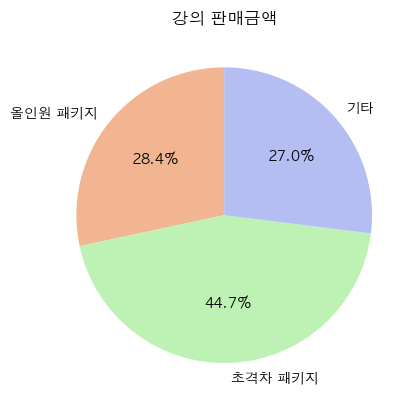

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터
values = [df_allinone, df_cho, df['거래금액'].sum() - df_allinone - df_cho]
labels = ['올인원 패키지', '초격차 패키지', '기타']

# 색상
colors = ['#F2B591', '#BEF2B4', '#B4BEF2']

# 그래프 그리기
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# 타이틀 설정
plt.title('강의 판매금액')

# 그래프 출력
plt.show()


In [102]:
keyword1 = "올인원 패키지"
keyword2 = "초격차 패키지"
num_products1 = len(df[df['코스(상품) 이름'].str.contains(keyword1)])
num_products2= len(df[df['코스(상품) 이름'].str.contains(keyword2)])
num_products3 = len(df['코스(상품) 이름']) - num_products1 - num_products2
print(f"'{keyword1}'를 포함하는 상품 이름의 개수: {num_products1}")
print(f"'{keyword2}'를 포함하는 상품 이름의 개수: {num_products2}")
print(f" 기타 개수: {num_products3}")

print("총 개수",num_products1 + num_products2 + num_products3)


'올인원 패키지'를 포함하는 상품 이름의 개수: 47590
'초격차 패키지'를 포함하는 상품 이름의 개수: 70380
 기타 개수: 41358
총 개수 159328


In [103]:
df_allinone = df_keyword1['거래금액'].sum()
df_cho = df_keyword2['거래금액'].sum()
df_기타 = df['거래금액'].sum() - df_allinone - df_cho

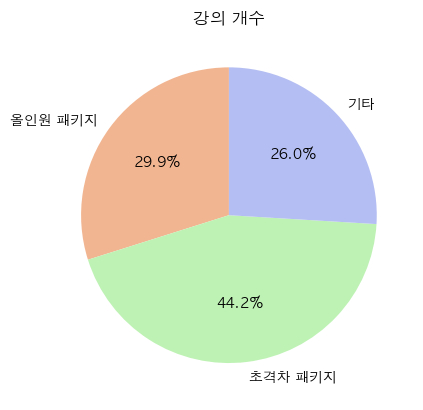

In [107]:
# 데이터
values = [num_products1,num_products2,num_products3]
labels = ['올인원 패키지', '초격차 패키지', '기타']

# 색상
colors = ['#F2B591', '#BEF2B4', '#B4BEF2']

# 그래프 그리기
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# 타이틀 설정
plt.title('강의 개수')

# 그래프 출력
plt.show()

In [115]:
# 상관 관계가 없다고 볼 수 있다..